In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/diabetes-prediction-dataset/diabetes_prediction_dataset.csv


In [2]:
pip install scikit-learn==1.4.2 imbalanced-learn==0.12.3


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.1/12.1 MB 83.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 258.3/258.3 kB 12.9 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.2.2
    Uninstalling scikit-learn-1.2.2:
      Successfully uninstalled scikit-learn-1.2.2
  Attempting uninstall: imbalanced-learn
    Found existing installation: imbalanced-learn 0.13.0
    Uninstalling imbalanced-learn-0.13.0:
      Successfully uninstalled imbalanced-learn-0.13.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cesium 0.12.4 requires numpy<3.0,>=2.0, but you have numpy 1.26.4 which is incompatible.
Note: you may need to restart the kernel to use updated packages.


In [3]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
import lightgbm as lgb
from sklearn.metrics import accuracy_score, f1_score,classification_report, confusion_matrix,ConfusionMatrixDisplay,roc_auc_score, roc_curve, precision_recall_curve, auc
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE


In [4]:
df=pd.read_csv("/kaggle/input/diabetes-prediction-dataset/diabetes_prediction_dataset.csv")
print(df.head())
df.shape

   gender   age  hypertension  heart_disease smoking_history    bmi  \
0  Female  80.0             0              1           never  25.19   
1  Female  54.0             0              0         No Info  27.32   
2    Male  28.0             0              0           never  27.32   
3  Female  36.0             0              0         current  23.45   
4    Male  76.0             1              1         current  20.14   

   HbA1c_level  blood_glucose_level  diabetes  
0          6.6                  140         0  
1          6.6                   80         0  
2          5.7                  158         0  
3          5.0                  155         0  
4          4.8                  155         0  


(100000, 9)

In [5]:
print(df.isnull().sum())

gender                 0
age                    0
hypertension           0
heart_disease          0
smoking_history        0
bmi                    0
HbA1c_level            0
blood_glucose_level    0
diabetes               0
dtype: int64


In [6]:
df.describe()

,age,hypertension,heart_disease,bmi,HbA1c_level,blood_glucose_level,diabetes
count,100000.000000,100000.00000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000
mean,41.885856,0.07485,0.039420,27.320767,5.527507,138.058060,0.085000
std,22.516840,0.26315,0.194593,6.636783,1.070672,40.708136,0.278883
min,0.080000,0.00000,0.000000,10.010000,3.500000,80.000000,0.000000
25%,24.000000,0.00000,0.000000,23.630000,4.800000,100.000000,0.000000
50%,43.000000,0.00000,0.000000,27.320000,5.800000,140.000000,0.000000
75%,60.000000,0.00000,0.000000,29.580000,6.200000,159.000000,0.000000
max,80.000000,1.00000,1.000000,95.690000,9.000000,300.000000,1.000000


In [7]:
class_dist=df["diabetes"].value_counts()*100/len(df["diabetes"])

In [8]:
print(df["smoking_history"].value_counts())
df["gender"].value_counts()

smoking_history
No Info        35816
never          35095
former          9352
current         9286
not current     6447
ever            4004
Name: count, dtype: int64


gender
Female    58552
Male      41430
Other        18
Name: count, dtype: int64

In [9]:
# One-hot encode smoking_history and gender
df= pd.get_dummies(df, columns=['smoking_history'], drop_first=True)
df= pd.get_dummies(df, columns=['gender'], drop_first=True)
df= df.astype(int)

print(df.head())


   age  hypertension  heart_disease  bmi  HbA1c_level  blood_glucose_level  \
0   80             0              1   25            6                  140   
1   54             0              0   27            6                   80   
2   28             0              0   27            5                  158   
3   36             0              0   23            5                  155   
4   76             1              1   20            4                  155   

   diabetes  smoking_history_current  smoking_history_ever  \
0         0                        0                     0   
1         0                        0                     0   
2         0                        0                     0   
3         0                        1                     0   
4         0                        1                     0   

   smoking_history_former  smoking_history_never  smoking_history_not current  \
0                       0                      1                            0

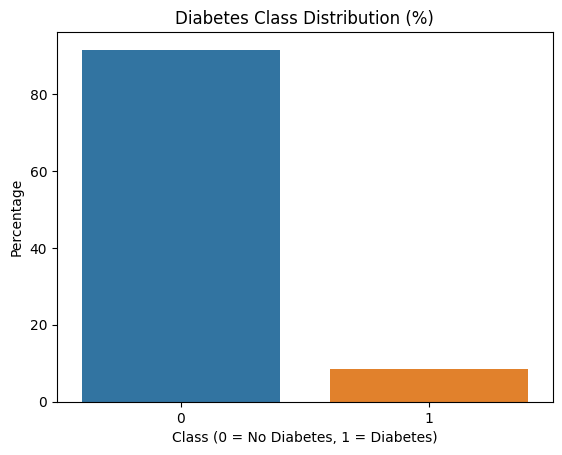

In [10]:


# Bar Plot
sns.barplot(x=class_dist.index, y=class_dist.values)
plt.title("Diabetes Class Distribution (%)")
plt.ylabel("Percentage")
plt.xlabel("Class (0 = No Diabetes, 1 = Diabetes)")
plt.show()

This is a **class imbalance** (about 91% vs 9%).
If you train a model directly, it might just predict 0 (No diabetes) most of the time and still get ~91% accuracy.

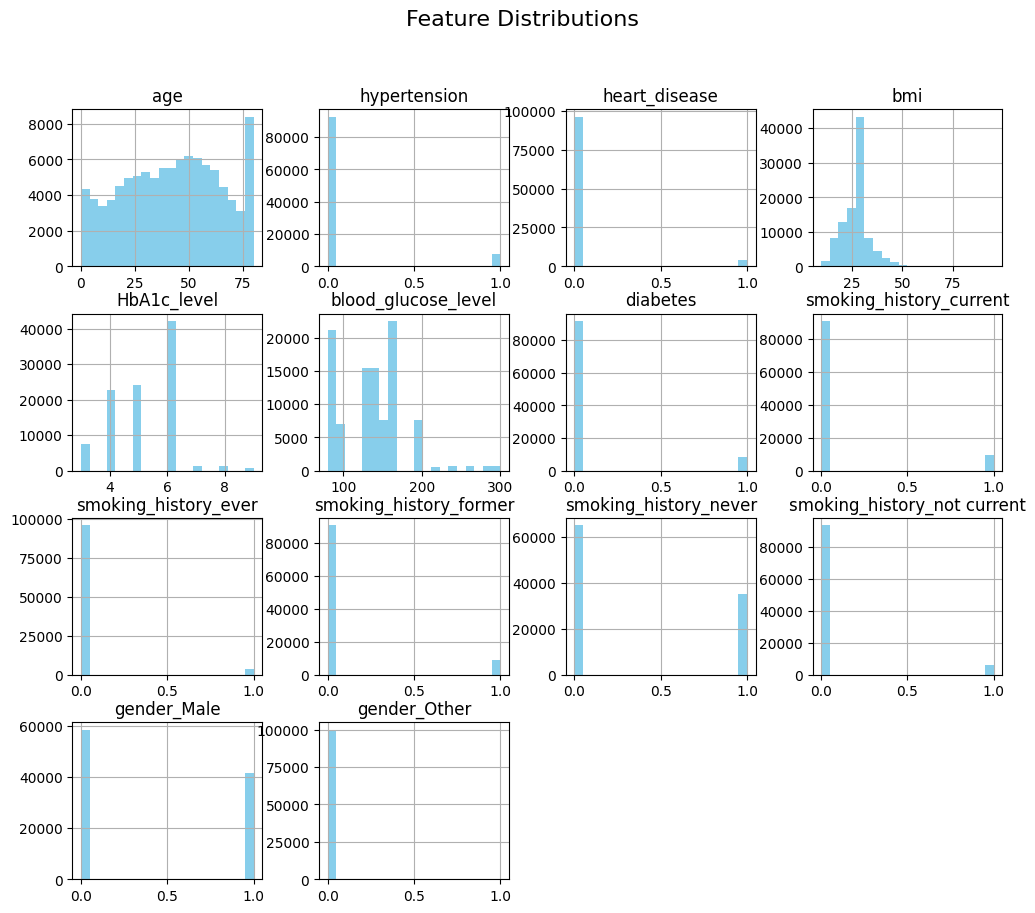

In [11]:
df.hist(bins=20, figsize=(12,10), color="skyblue")
plt.suptitle("Feature Distributions", fontsize=16)
plt.show()


**To see how values are distributed in Features*> *****

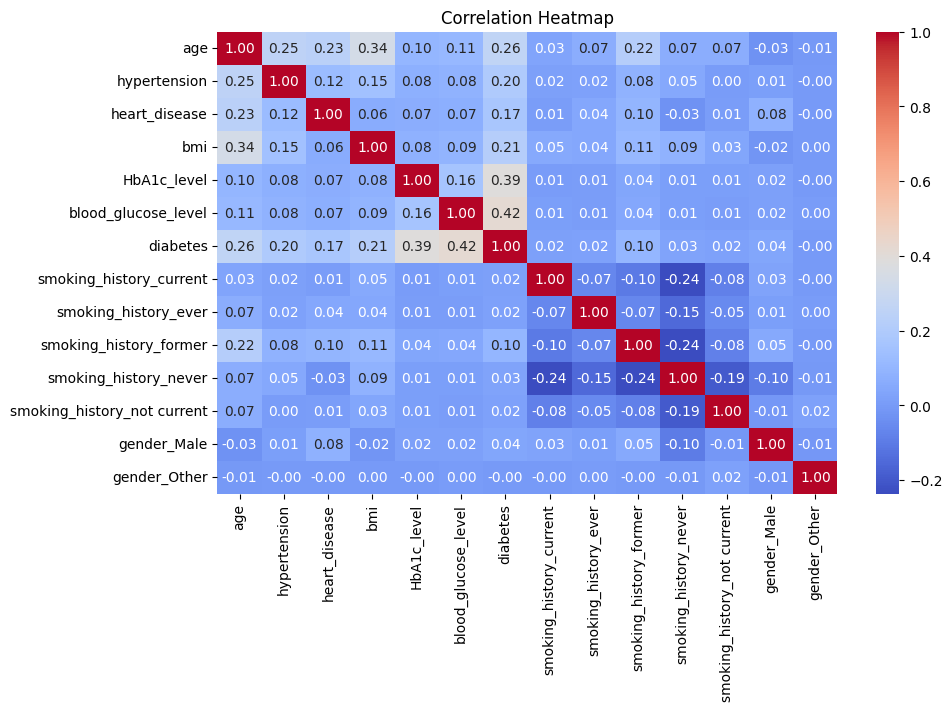

In [12]:
plt.figure(figsize=(10,6))
sns.heatmap(df.corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Heatmap")
plt.show()


**IT shows the relationships between features and the target**

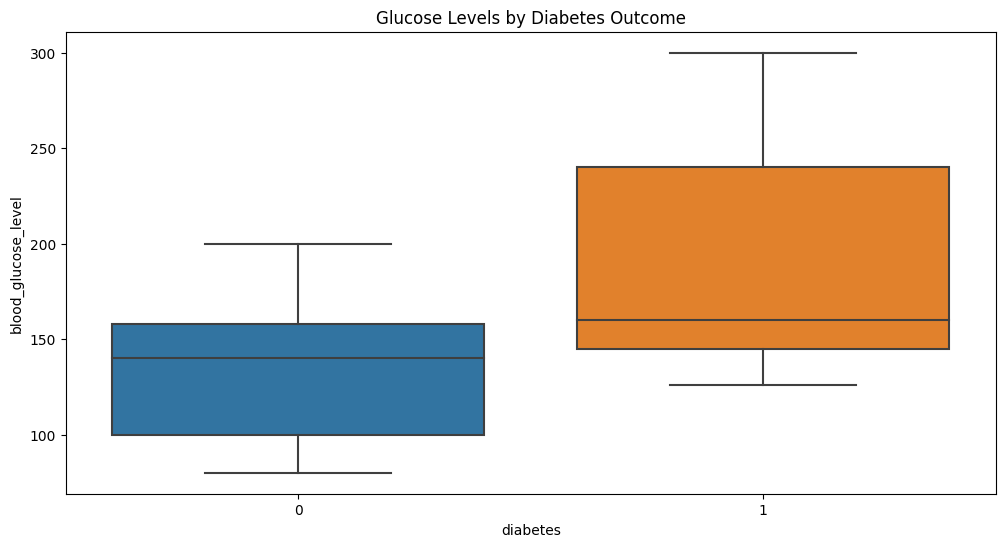

In [13]:
plt.figure(figsize=(12,6))
sns.boxplot(x="diabetes", y="blood_glucose_level", data=df)
plt.title("Glucose Levels by Diabetes Outcome")
plt.show()


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-l

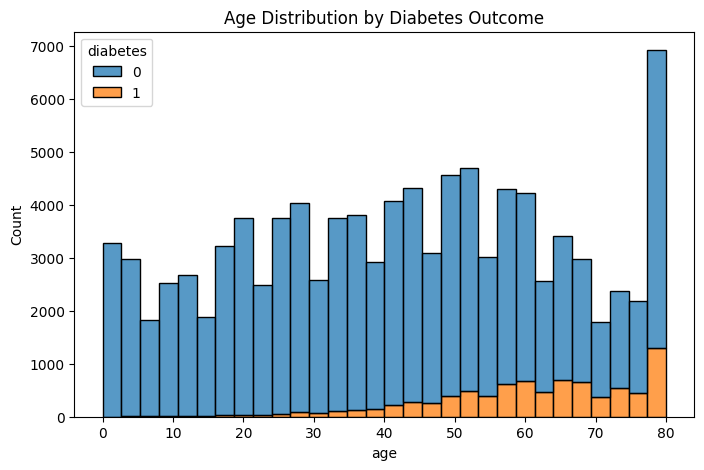

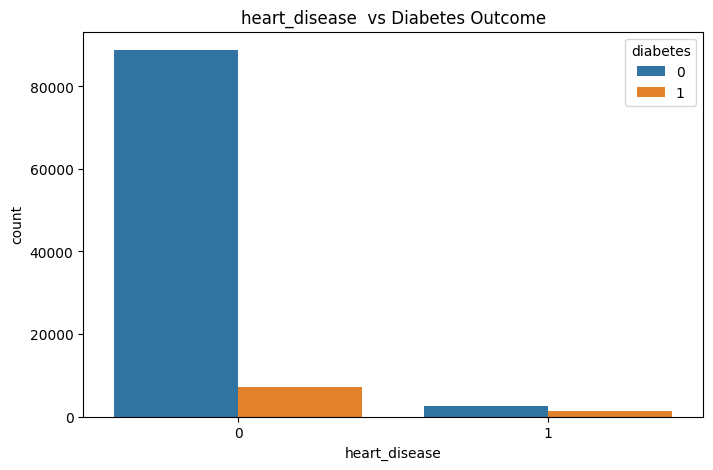

In [14]:
plt.figure(figsize=(8,5))
sns.histplot(data=df, x="age", hue="diabetes", multiple="stack", bins=30)
plt.title("Age Distribution by Diabetes Outcome")
plt.show()
plt.figure(figsize=(8,5))
sns.countplot(x="heart_disease", hue="diabetes", data=df)
plt.title("heart_disease  vs Diabetes Outcome")
plt.show()


In [15]:
x = df.drop("diabetes", axis=1)
y = df["diabetes"]

# MODEL TRAINING WITHOUT **standardization** and **SMOTE**

In [16]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, stratify=y, random_state=42)

In [17]:
log_reg = LogisticRegression(max_iter=1000)
log_reg.fit(X_train, y_train)
y_pred_log = log_reg.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred_log))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_log))
print("Classification Report:\n", classification_report(y_test, y_pred_log))

Accuracy: 0.9582
Confusion Matrix:
 [[18114   186]
 [  650  1050]]
Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.99      0.98     18300
           1       0.85      0.62      0.72      1700

    accuracy                           0.96     20000
   macro avg       0.91      0.80      0.85     20000
weighted avg       0.96      0.96      0.96     20000



In [18]:
# Random Forest
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred_rf))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_rf))
print("Classification Report:\n", classification_report(y_test, y_pred_rf))


Accuracy: 0.96125
Confusion Matrix:
 [[18116   184]
 [  591  1109]]
Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.99      0.98     18300
           1       0.86      0.65      0.74      1700

    accuracy                           0.96     20000
   macro avg       0.91      0.82      0.86     20000
weighted avg       0.96      0.96      0.96     20000



In [19]:

# XGBoost
xgb = XGBClassifier(use_label_encoder=False, eval_metric="logloss", random_state=42)
xgb.fit(X_train, y_train)
y_pred_xgb = xgb.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred_xgb))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_xgb))
print("Classification Report:\n", classification_report(y_test, y_pred_xgb))


Accuracy: 0.967
Confusion Matrix:
 [[18233    67]
 [  593  1107]]
Classification Report:
               precision    recall  f1-score   support

           0       0.97      1.00      0.98     18300
           1       0.94      0.65      0.77      1700

    accuracy                           0.97     20000
   macro avg       0.96      0.82      0.88     20000
weighted avg       0.97      0.97      0.96     20000



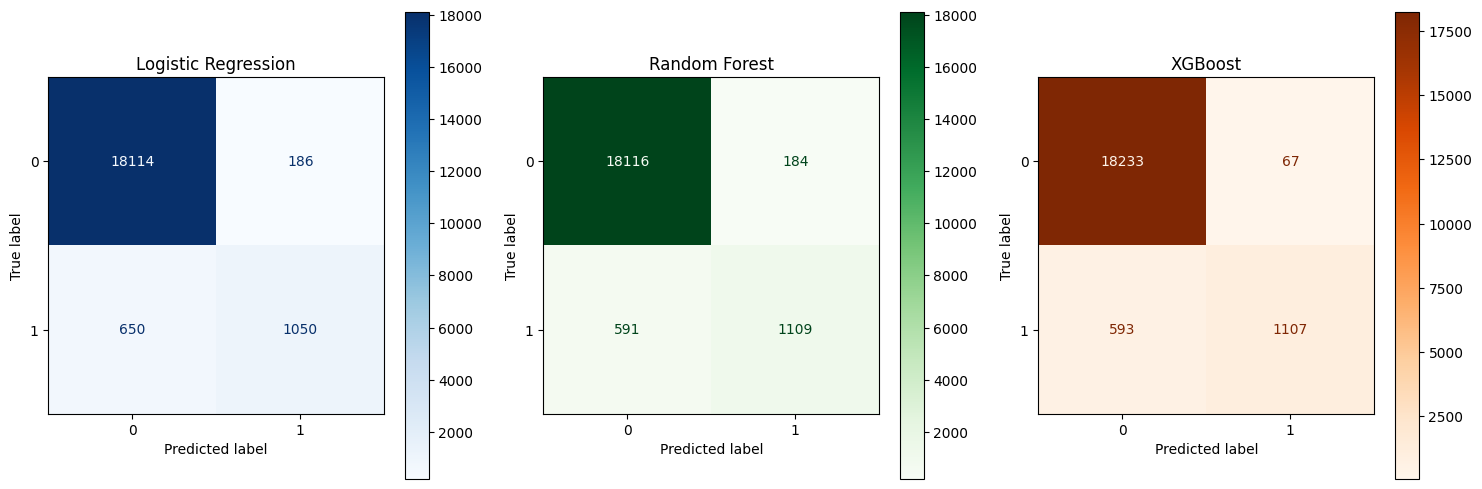

In [20]:
y_pred_log = log_reg.predict(X_test)
y_pred_rf = rf.predict(X_test)
y_pred_xgb = xgb.predict(X_test)

cm_log = confusion_matrix(y_test, y_pred_log)
cm_rf = confusion_matrix(y_test, y_pred_rf)
cm_xgb = confusion_matrix(y_test, y_pred_xgb)

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

ConfusionMatrixDisplay(cm_log, display_labels=[0,1]).plot(ax=axes[0], cmap="Blues", values_format='d')
axes[0].set_title("Logistic Regression")

ConfusionMatrixDisplay(cm_rf, display_labels=[0,1]).plot(ax=axes[1], cmap="Greens", values_format='d')
axes[1].set_title("Random Forest")

ConfusionMatrixDisplay(cm_xgb, display_labels=[0,1]).plot(ax=axes[2], cmap="Oranges", values_format='d')
axes[2].set_title("XGBoost")

plt.tight_layout()
plt.show()

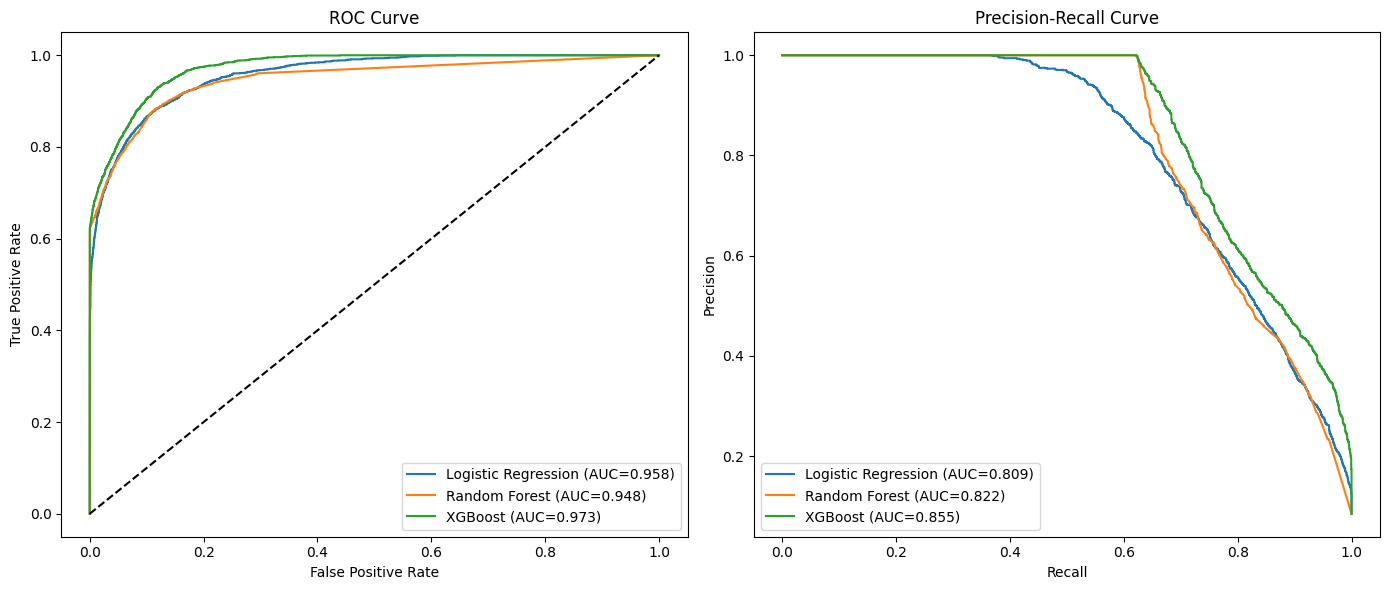

In [21]:
def plot_curves(models, X_test, y_test):
    plt.figure(figsize=(14,6))
    
    # ROC Curve
    plt.subplot(1,2,1)
    for name, model in models.items():
        y_probs = model.predict_proba(X_test)[:,1]
        fpr, tpr, _ = roc_curve(y_test, y_probs)
        roc_auc = roc_auc_score(y_test, y_probs)
        plt.plot(fpr, tpr, label=f"{name} (AUC={roc_auc:.3f})")
    plt.plot([0,1], [0,1], "k--")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve")
    plt.legend()

    # PR Curve
    plt.subplot(1,2,2)
    for name, model in models.items():
        y_probs = model.predict_proba(X_test)[:,1]
        precision, recall, _ = precision_recall_curve(y_test, y_probs)
        pr_auc = auc(recall, precision)
        plt.plot(recall, precision, label=f"{name} (AUC={pr_auc:.3f})")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title("Precision-Recall Curve")
    plt.legend()
    
    plt.tight_layout()
    plt.show()


models = {
    "Logistic Regression": log_reg,
    "Random Forest": rf,
    "XGBoost": xgb
}

plot_curves(models, X_test, y_test)

# Model Evaluation: ROC-AUC and PR-AUC

---

## 1. ROC Curve (left side)
- **ROC (Receiver Operating Characteristic)** shows how well the model separates **positive vs. negative classes** across thresholds.  
- **X-axis:** False Positive Rate (FPR)  
- **Y-axis:** True Positive Rate (TPR)  

 **Interpretation:**  
- A perfect model would hug the **top-left corner** (TPR = 1, FPR = 0).  
- The **dotted diagonal line** is random guessing (AUC = 0.5).  
- **Higher curve = better separation of classes.**

**Results (AUC scores):**
- Logistic Regression → **0.958** (very good)  
- Random Forest → **0.948** (slightly worse than Logistic)  
- XGBoost → **0.973** (best separation, closer to perfect classifier)  

 **Conclusion:** XGBoost performs best at distinguishing between diabetic vs. non-diabetic patients.

---

## 2. Precision-Recall (PR) Curve (right side)
- **Precision:** Out of all predicted positives, how many are correct?  
- **Recall (Sensitivity):** Out of all actual positives, how many are found?  
- Important for **imbalanced datasets** (like diabetes, where positive class is usually smaller).  

 **Interpretation:**  
- Curve closer to **top-right corner** = better model.  
- **PR-AUC** shows tradeoff: higher AUC = better balance between precision and recall.  

**Results (PR-AUC scores):**
- Logistic Regression → **0.809**  
- Random Forest → **0.822**  
- XGBoost → **0.855** (again best)  

 **Conclusion:**  
- Logistic Regression & Random Forest are close, but XGBoost clearly wins, especially in handling imbalance (higher PR-AUC).  

---


- **ROC-AUC (overall separation):** XGBoost > Logistic Regression > Random Forest  
- **PR-AUC (for imbalance):** XGBoost > Random Forest > Logistic Regression  
- **Best model overall:**  **XGBoost**


# WITH  standardization and SMOTE
**STANDARDIZATION**:Transforms data to have mean = 0 and standard deviation = 1.



In [22]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [23]:
log_reg = LogisticRegression(max_iter=1000)
log_reg.fit(X_train_scaled, y_train)
y_pred_log = log_reg.predict(X_test_scaled)
print("Accuracy:", accuracy_score(y_test, y_pred_log))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_log))
print("Classification Report:\n", classification_report(y_test, y_pred_log))

Accuracy: 0.95815
Confusion Matrix:
 [[18114   186]
 [  651  1049]]
Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.99      0.98     18300
           1       0.85      0.62      0.71      1700

    accuracy                           0.96     20000
   macro avg       0.91      0.80      0.85     20000
weighted avg       0.96      0.96      0.96     20000



# **SMOTE :** Handle Imbalance 

In [24]:
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train_scaled, y_train)

print("Before SMOTE:", y_train.value_counts())
print("After SMOTE:", y_train_res.value_counts())

Before SMOTE: diabetes
0    73200
1     6800
Name: count, dtype: int64
After SMOTE: diabetes
1    73200
0    73200
Name: count, dtype: int64


In [25]:
log_reg = LogisticRegression(max_iter=1000, random_state=42)
log_reg.fit(X_train_res, y_train_res)
y_pred_log_v2 = log_reg.predict(X_test_scaled)
print("Accuracy:", accuracy_score(y_test, y_pred_log_v2))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_log_v2))
print("Classification Report:\n", classification_report(y_test, y_pred_log_v2))

Accuracy: 0.88455
Confusion Matrix:
 [[16186  2114]
 [  195  1505]]
Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.88      0.93     18300
           1       0.42      0.89      0.57      1700

    accuracy                           0.88     20000
   macro avg       0.70      0.88      0.75     20000
weighted avg       0.94      0.88      0.90     20000



In [26]:
rf = RandomForestClassifier(n_estimators=200, random_state=42)
rf.fit(X_train_res, y_train_res)
y_pred_rf_v2 = rf.predict(X_test_scaled)
print("Accuracy:", accuracy_score(y_test, y_pred_rf_v2))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_rf_v2))
print("Classification Report:\n", classification_report(y_test, y_pred_rf_v2))

Accuracy: 0.9494
Confusion Matrix:
 [[17787   513]
 [  499  1201]]
Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.97      0.97     18300
           1       0.70      0.71      0.70      1700

    accuracy                           0.95     20000
   macro avg       0.84      0.84      0.84     20000
weighted avg       0.95      0.95      0.95     20000



In [27]:
xgb = XGBClassifier(use_label_encoder=False, eval_metric="logloss", random_state=42)
xgb.fit(X_train_res, y_train_res)
y_pred_xgb_v2 = xgb.predict(X_test_scaled)
print("Accuracy:", accuracy_score(y_test, y_pred_xgb_v2))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_xgb_v2))
print("Classification Report:\n", classification_report(y_test, y_pred_xgb_v2))

Accuracy: 0.96395
Confusion Matrix:
 [[18116   184]
 [  537  1163]]
Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.99      0.98     18300
           1       0.86      0.68      0.76      1700

    accuracy                           0.96     20000
   macro avg       0.92      0.84      0.87     20000
weighted avg       0.96      0.96      0.96     20000



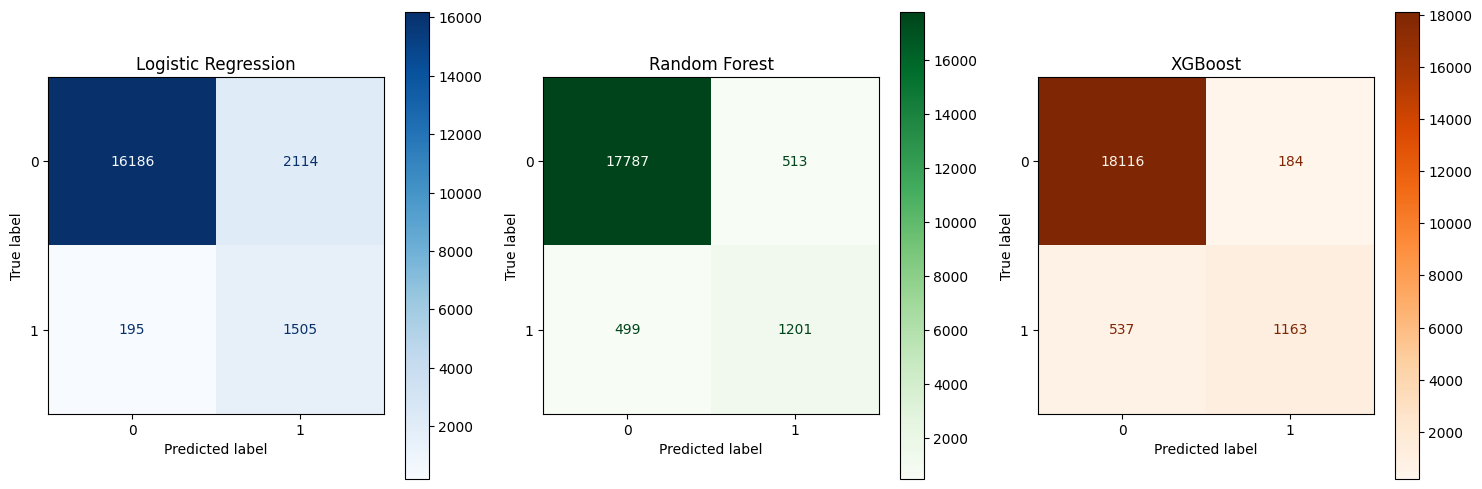

In [28]:
y_pred_log_v2 = log_reg.predict(X_test_scaled)
y_pred_rf_v2 = rf.predict(X_test_scaled)
y_pred_xgb_v2 = xgb.predict(X_test_scaled)
cm_log_v2 = confusion_matrix(y_test, y_pred_log_v2)
cm_rf_v2 = confusion_matrix(y_test, y_pred_rf_v2)
cm_xgb_v2 = confusion_matrix(y_test, y_pred_xgb_v2)

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

ConfusionMatrixDisplay(cm_log_v2, display_labels=[0,1]).plot(ax=axes[0], cmap="Blues", values_format='d')
axes[0].set_title("Logistic Regression")

ConfusionMatrixDisplay(cm_rf_v2, display_labels=[0,1]).plot(ax=axes[1], cmap="Greens", values_format='d')
axes[1].set_title("Random Forest")

ConfusionMatrixDisplay(cm_xgb_v2, display_labels=[0,1]).plot(ax=axes[2], cmap="Oranges", values_format='d')
axes[2].set_title("XGBoost")

plt.tight_layout()
plt.show()

###  With vs Without Standardization + SMOTE

| Model                | Accuracy (No SMOTE) | Recall (Class 1, No SMOTE) | Accuracy (SMOTE) | Recall (Class 1, SMOTE) | Observation |
|----------------------|----------------------|----------------------------|------------------|--------------------------|-------------|
| Logistic Regression  | 0.958               | 0.62                       | 0.884            | 0.89                     | Recall improved, but accuracy dropped |
| Random Forest        | 0.961               | 0.65                       | 0.949            | 0.71                     | Balanced improvement |
| XGBoost              | 0.967               | 0.65                       | 0.963            | 0.68                     | Still best overall |

###  Key Takeaways
- **Without SMOTE:** Higher accuracy but poor recall → many diabetics missed.  
- **With SMOTE:** Lower accuracy but higher recall → better at detecting diabetics.  
# healthcare projects:  **Recall (Sensitivity) is more important than raw Accuracy.**

A false positive (non-diabetic flagged as diabetic) → Patient does one extra test ✅.

A false negative (diabetic flagged as non-diabetic) → Patient goes untreated ❌ (much worse).

# FINAL RESULT
Here prioritize Recall (Sensitivity) **High recall** is essential when missing positive cases has significant consequences like in **medical tests**.
Goal → Catch as many true diabetics as possible, even if you make more false alarms.

Useful in healthcare screening: missing a diabetic is worse than a false alarm, because an undiagnosed patient won’t get treatment.

Best Choice → **Logistic Regression (WITH  standardization and SMOTE)**

Recall jumps to** ~89%** (you catch most diabetics ).

Accuracy drops to ~88% → more false positives, but that’s okay in screening in medical field